In [1]:
#calibration part 1
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# read in a collection of chessboard images with which to calibrate the camera

images = glob.glob('C:/lines/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

#arrays to store object points and image points from all the calibrations
objpoints = [] #3D points in real world space (will all be the same)
imgpoints = [] #2D points in image plane

#prepare obj points
objp = np.zeros((6*9,3), np.float32)  
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x and y coords

for fname in images:
    img = mpimg.imread(fname)

    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    #if corners are found, add obj and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)



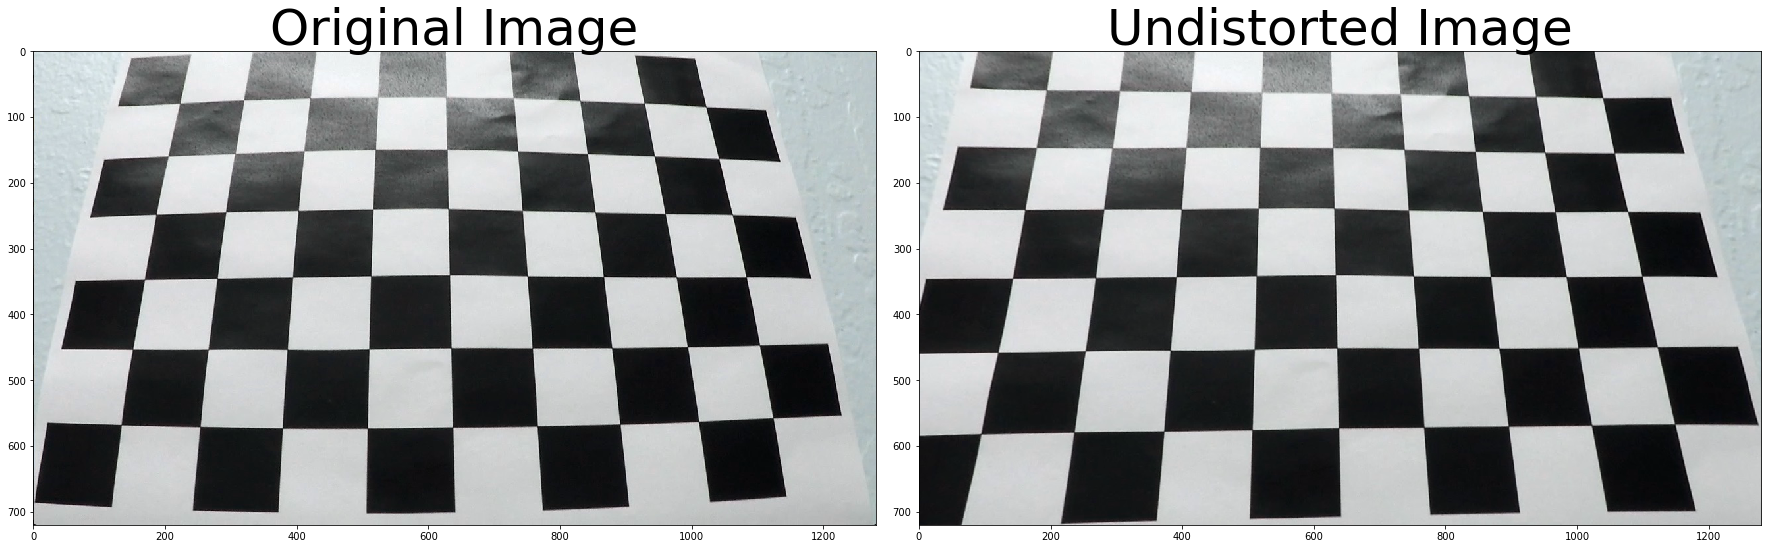

In [2]:
# Calibration Part 2
img_t = cv2.imread('C:/lines/CarND-Advanced-Lane-Lines/camera_cal/calibration3.jpg')

gray = cv2.cvtColor(img_t,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_t.shape[0:2], None, None)
undist = cv2.undistort(img_t, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_t)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [3]:
#undistort image from video frame

def undistort_image(distimg):
    #img_str = cv2.imread('C:/lines/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

    image_rgb = cv2.cvtColor(distimg,cv2.COLOR_BGR2RGB)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_rgb.shape[0:2], None, None)
    undist = cv2.undistort(image_rgb, mtx, dist, None, mtx)
    
    return undist


In [4]:
# Apply Sobel and then compute direction of the gradient and apply threshold 

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #convert to grayscale
    
    sobelx = cv2.Sobel(grayimage, cv2.CV_64F, 1, 0, ksize = sobel_kernel) #gradient x
    sobely = cv2.Sobel(grayimage, cv2.CV_64F, 0, 1, ksize = sobel_kernel) #gradient y
    
    absx = np.absolute(sobelx) #abs val of x gradient
    absy = np.absolute(sobely) #abs val of y gradient
    
    direction = np.arctan2(absy, absx) #calc direction of gradient
    
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1 #binary mask
    
    binary_output = sxbinary #this is probably unnecessary
    
    return binary_output

In [5]:
#Apply Sobel threshold

def abs_sobel_thresh(img, orient='x', thresh_min=5, thresh_max=100):
    
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #convert to grayscale
    
    sobelx = cv2.Sobel(grayimage, cv2.CV_64F, 1, 0) #derivative in x
    
    absval = np.absolute(sobelx) #abs val of the derivative
    
    scaledimg = np.uint8(255 * absval/np.max(absval)) #scale to 8-bit, then convert to np.uint8
    
    sxbinary = np.zeros_like(scaledimg) 
    sxbinary[(scaledimg >= thresh_min) & (scaledimg <= thresh_max)] = 1 #mask to show where gradient is in range
    
    binary_output = sxbinary
    
    return binary_output


In [6]:
#HLS threshold based on S channel

def hls_select(img, thresh=(0, 255)):
    
    imagehls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) #convert from RGB to HLS
    
    imgs = imagehls[:,:,2]
    binary = np.zeros_like(imgs)
    binary[(imgs > thresh[0]) & (imgs <= thresh[1])] = 1 #threshold to S channel appplied
    
    binary_output = binary
    
    return binary_output

In [7]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[717, 469], [1013, 657], [286, 657], [563, 469]])
    dst = np.float32([[850, 200], [850, 657], [350, 657], [350, 200]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) 

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

In [12]:
#this is the main point of the pipeline - finding the lane lines

#assign binwrpd; I tried different images from here down in various iterations,
#but it was easier to just change the reference once here

def major_process(image, uvf):

    binwrpd = image

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binwrpd[binwrpd.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binwrpd, binwrpd, binwrpd))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
       
    
    leftforctr = leftx_base
    rightforctr = rightx_base
    
    #these two if statements are intended to keep the lane line from jumping way to the left or right if the historgram is
    #not 100% successful
    
    if leftforctr<100:
        leftx_base=350
    
    if rightforctr>1000:
        rightx_base=850
        

    #here I am determining the position of the vehcle within the lane based on the center of the image compared to the
    #calculated center of the lane; might as well write the text message for the output image while we're here
    lanectr = (rightx_base+leftx_base)/2
    diff = 640-lanectr
    if diff<0:
        ltdiff = -diff
        ltmeter = ltdiff*3.7/500
        lttwo = "%0.2f" % ltmeter
        lmtxt = str(lttwo)
        difftxt = "vehicle is "+lmtxt+"m left of lane center"
    
    if diff>0:
        rtmeter = diff*3.7/500
        rttwo = "%0.2f" % rtmeter
        rmtxt = str(rttwo)
        difftxt = "vehicle is "+rmtxt+"m right of lane center"
    
    if diff==0:
        difftxt = "vehicle is centered in the lane"


    # Choose the number of sliding windows with which to examine the image
    nwindows = 9
    # Set height of windows
    window_height = np.int(binwrpd.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binwrpd.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binwrpd.shape[0] - (window+1)*window_height
        win_y_high = binwrpd.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #print(win_xleft_low,win_y_low, win_xleft_high,win_y_high)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            oldleft=leftx_current
            leftx_current_a = np.int(np.mean(nonzerox[good_left_inds]))       
            ltdiff = leftx_current_a - leftx_current
            if ltdiff>80:
                leftx_current = oldleft+80
        
        if len(good_right_inds) > minpix:
            oldright=rightx_current
            rightx_current_a = np.int(np.mean(nonzerox[good_right_inds]))
            rtdiff = rightx_current_a - rightx_current
            if rtdiff>80:
                rightx_current = oldright+80
            
        
        #these two if statement follow up on the error-avoidance earlier in this cell - if the recentered window is way out of
        #what would seem to be reasonable, it reverts back to what was just used
        if leftx_current<100:
            leftx_current=leftx_base
        
        if rightx_current>1200:
            rightx_current=rightx_base

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binwrpd.shape[0]-1, binwrpd.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/500 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binwrpd).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    src = np.float32([[712, 469], [1013, 657], [286, 657], [563, 469]])
    dst = np.float32([[850, 200], [850, 657], [350, 657], [350, 200]])

    Minv = cv2.getPerspectiveTransform(dst, src)
    
      
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
        
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binwrpd.shape[1], binwrpd.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(uvf, 1, newwarp, 0.3, 0)
    
    lefttxt = str(left_curverad)
    righttxt = str(right_curverad)

    text = 'left radius: ' + lefttxt + 'm; right radius: ' + righttxt + 'm'

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    result_w_txt_a = cv2.putText(result, text,(20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result_w_txt = cv2.putText(result_w_txt_a, difftxt, (20,100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return result_w_txt


In [13]:
# Read in an image

def process_image(video_frame):
       
    image_rgb1 = cv2.cvtColor(video_frame,cv2.COLOR_BGR2RGB)

    uvf=undistort_image(image_rgb1)

    vfdt=dir_threshold(uvf, sobel_kernel=15, thresh=(0.7, 1.3))
    vfst=abs_sobel_thresh(uvf, orient='x', thresh_min=20, thresh_max=100)
    vfhs=hls_select(uvf, thresh=(90, 255))

    vfcmbd = np.zeros_like(vfdt)
    vfcmbd[(vfdt == 1) & (vfst == 1) | (vfhs == 1)] = 1

    wrpdvf=warp(vfcmbd)

    vf_with_lines = major_process(wrpdvf, uvf)
   
    return vf_with_lines



In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:

output = 'test_12_3.mp4'
clip1 = VideoFileClip("project_video.mp4")
process_clip = clip1.fl_image(process_image) 
%time process_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_12_3.mp4
[MoviePy] Writing video test_12_3.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:34<00:01,  1.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_12_3.mp4 

Wall time: 35min 36s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))